<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Cartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [0]:
tar = tarfile.open('/content/drive/My Drive/Animado/real.tar.gz')
tar.extractall()
tar = tarfile.open('/content/drive/My Drive/Animado/cartoon.tar.gz')
tar.extractall()
import pandas as pd
at = pd.read_csv('/content/drive/My Drive/Animado/DATOSANIME.csv',sep=",")
at.shape

os.chdir('/content/realFaces')
real = []
for i in range(8928):
  if at.a[i]=='CharlieChaplin0003.jpg':
    at.a[i]='Charlie0003.jpg'
  img = load_img(at.a[i])
  img= img.resize((66,80))
  img_array = img_to_array(img)
  img_array = img_array/255
  real.append(img_array)
  
os.chdir('/content/cartoonFaces')
cartoon = []
for i in range(8928):
  img = load_img(at.q2[i])
  img= img.resize((68,80))
  img_array = img_to_array(img)
  img_array = img_array/255
  cartoon.append(img_array)

In [0]:
real = np.array(real) 
cartoon = np.array(cartoon)
print(real.shape)
print(cartoon.shape)

(8928, 80, 66, 3)
(8928, 80, 68, 3)


In [0]:
from sklearn.model_selection import train_test_split
real,test=train_test_split(real, test_size=0.2, random_state=42)
cartoon,test2=train_test_split(cartoon, test_size=0.2, random_state=42)

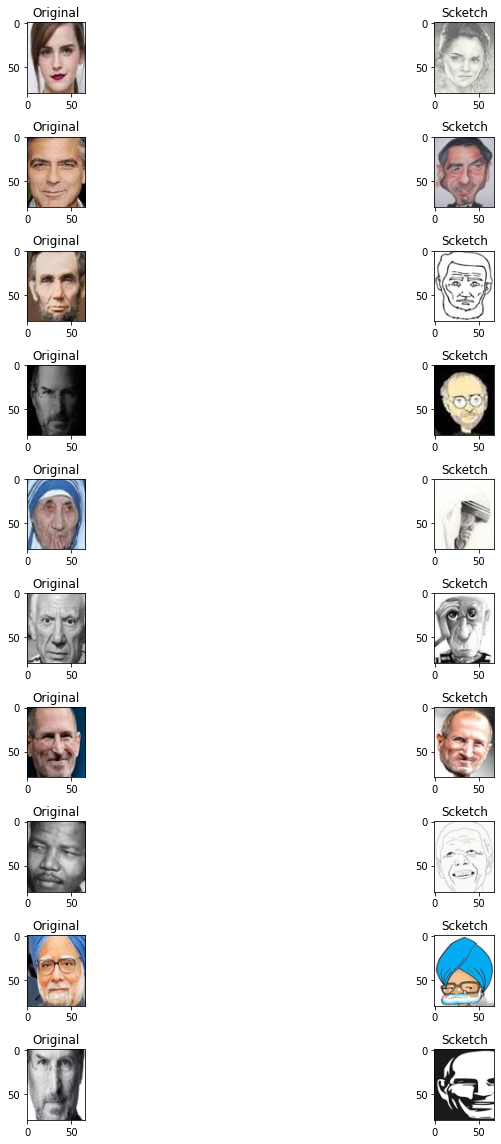

In [0]:
os.chdir('/content/drive/My Drive/Animado')
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(10, 2, figsize=(16,16))
ax = axes.ravel()
r=0
for i in range(80,90):
  ax[r].imshow(real[i])
  ax[r].set_title("Original")
  ax[r+1].imshow(cartoon[i])
  ax[r+1].set_title("Scketch")
  r=r+2

fig.tight_layout()
plt.show()

In [0]:
input_shape = real[1].shape
batch_size = 32
kernel_size = 3
latent_dim = 2000

In [0]:
print(real[3].shape)
print(cartoon[4].shape)

(80, 66, 3)
(80, 68, 3)


(None, 40, 33, 32)
(None, 20, 17, 64)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 80, 66, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 33, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 17, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 21760)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 2000)              43522000  
Total params: 43,541,392
Trainable params: 43,541,392
Non-trainable params: 0
_________________________________________________________________


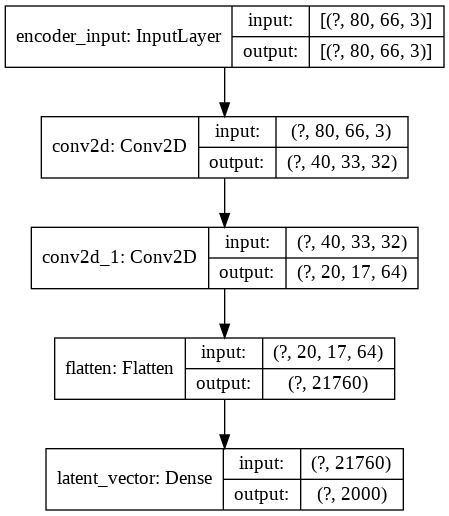

In [0]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    shape = K.int_shape(x)
    print(shape)
    
shape = K.int_shape(x)    
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)



In [0]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
x.shape

TensorShape([None, 20, 17, 64])

In [0]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2000)]            0         
_________________________________________________________________
dense (Dense)                (None, 21760)             43541760  
_________________________________________________________________
reshape (Reshape)            (None, 20, 17, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 40, 34, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 80, 68, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 80, 68, 3)         867       
Total params: 43,598,019
Trainable params: 43,598,019
Non-trainable params: 0
_______________________________________________

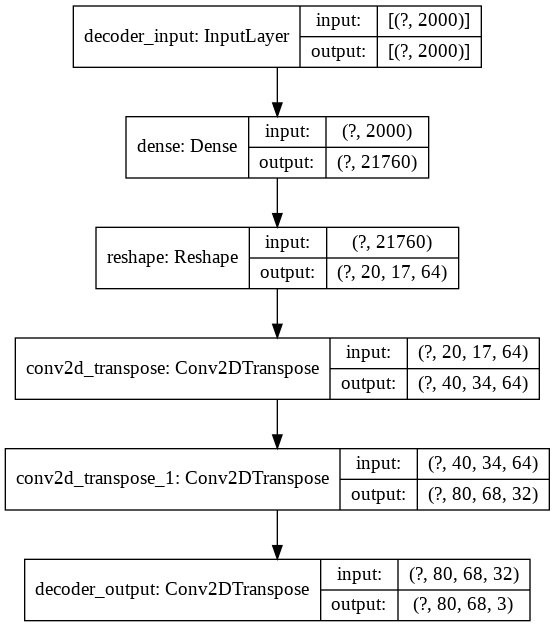

In [0]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 80, 66, 3)]       0         
_________________________________________________________________
encoder (Model)              (None, 2000)              43541392  
_________________________________________________________________
decoder (Model)              (None, 80, 68, 3)         43598019  
Total params: 87,139,411
Trainable params: 87,139,411
Non-trainable params: 0
_________________________________________________________________


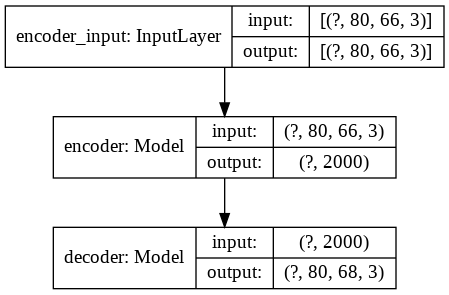

In [0]:
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

In [0]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [0]:
import tensorflow as tf
import keras
os.chdir('/content/drive/My Drive/Animado')
checkpoint_path = "training_1/cp_{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [0]:
# train the autoencoder
history= autoencoder.fit(real,
                cartoon,
                validation_split=0.1,
                batch_size=32,
                callbacks=[cp_callback],
                epochs=300)

Epoch 1/300
201/201 [==============================] - 9s 43ms/step - loss: 0.0910 - val_loss: 0.0880
Epoch 2/300
201/201 [==============================] - 22s 109ms/step - loss: 0.0884 - val_loss: 0.0858
Epoch 3/300
201/201 [==============================] - 25s 126ms/step - loss: 0.0859 - val_loss: 0.0847
Epoch 4/300
201/201 [==============================] - 4s 21ms/step - loss: 0.0843 - val_loss: 0.0848
Epoch 5/300
201/201 [==============================] - 19s 94ms/step - loss: 0.0828 - val_loss: 0.0846
Epoch 6/300
201/201 [==============================] - 31s 154ms/step - loss: 0.0814 - val_loss: 0.0842
Epoch 7/300
201/201 [==============================] - 4s 20ms/step - loss: 0.0806 - val_loss: 0.0856
Epoch 8/300
201/201 [==============================] - 4s 22ms/step - loss: 0.0802 - val_loss: 0.0859
Epoch 9/300
201/201 [==============================] - 4s 21ms/step - loss: 0.0794 - val_loss: 0.0853
Epoch 10/300
201/201 [==============================] - 4s 21ms/step - loss

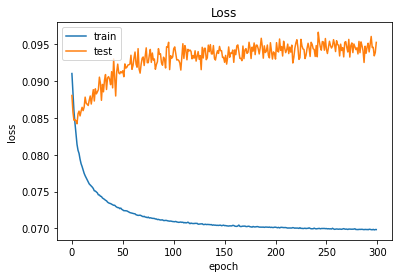

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
autoencoder.load_weights('/content/drive/My Drive//training_1/cp_.ckpt')

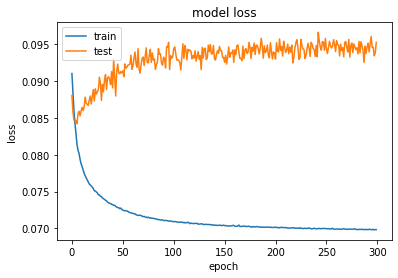

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
autoencoder.evaluate(test,test2, verbose=2)

56/56 - 1s - loss: 0.0957


0.0957116186618805

In [0]:
x_decoded = autoencoder.predict(test)

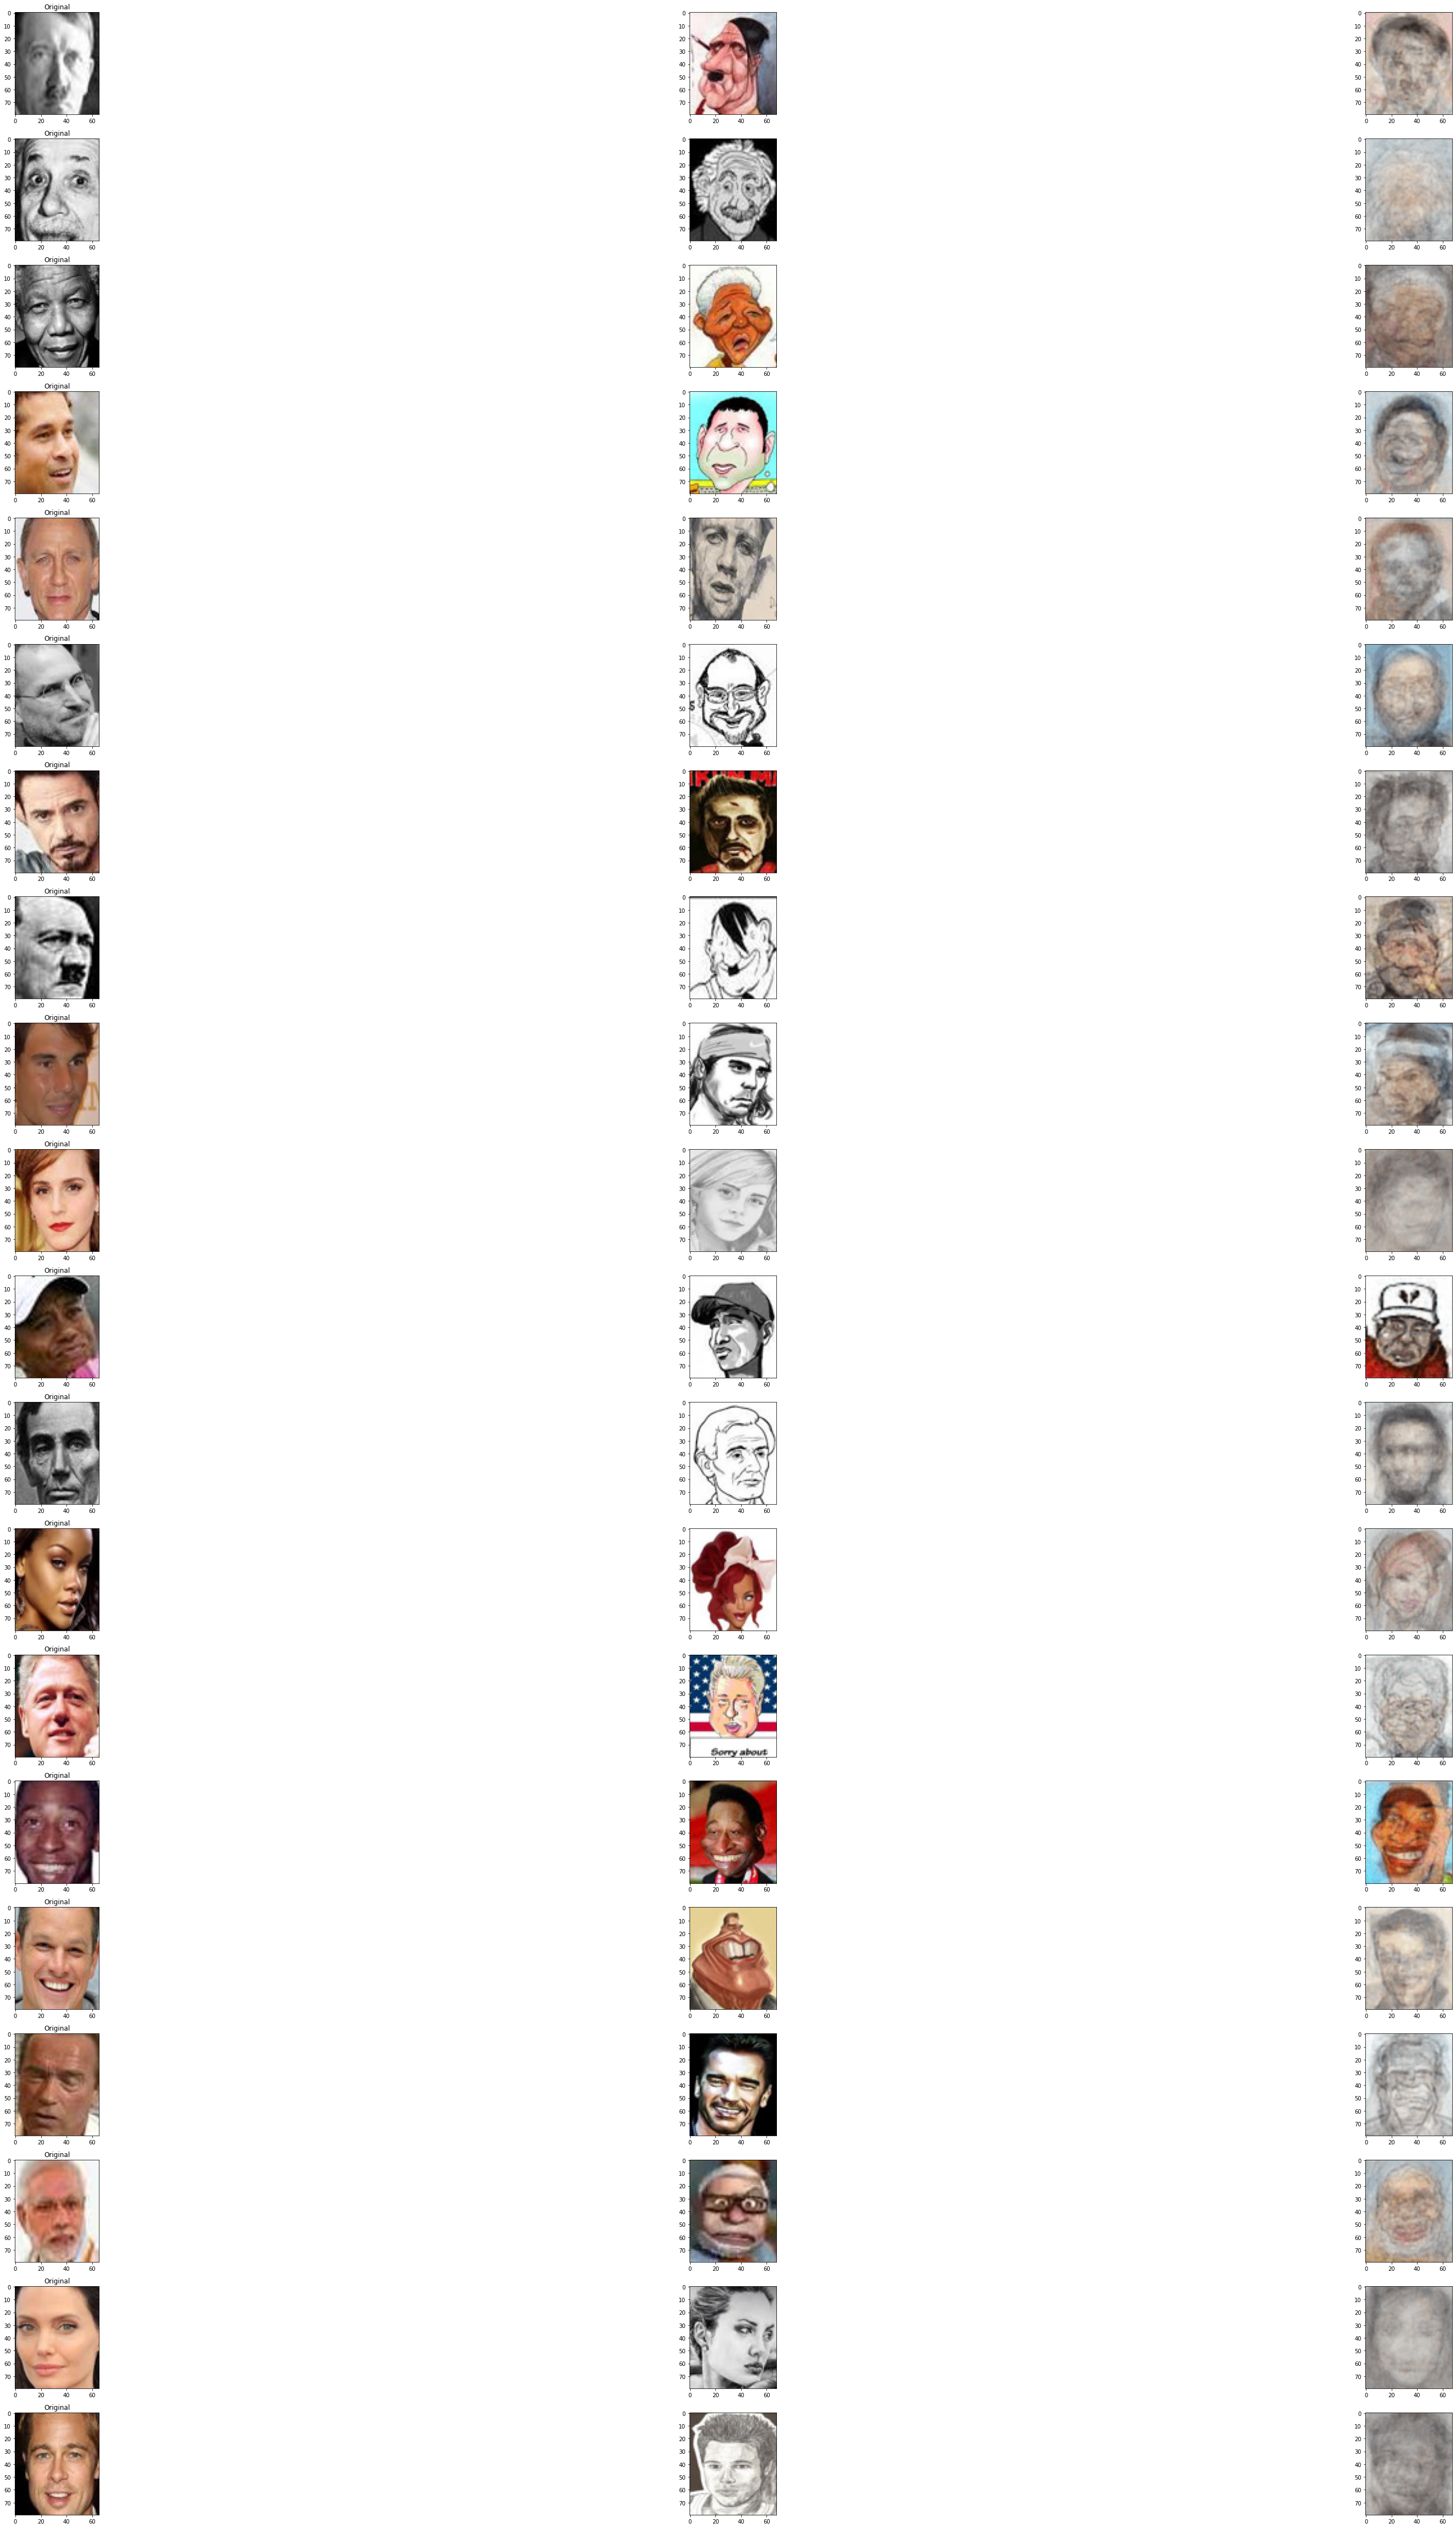

In [0]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(20, 3, figsize=(64,64))
ax = axes.ravel()
r=0
for i in range(0,20):
  ax[r].set_title("Original")
  ax[r].imshow(test[i])
  ax[r+1].imshow(test2[i])
  image = np.squeeze(x_decoded[i])
  ax[r+2].imshow(image)
  r=r+3

fig.tight_layout()
plt.show()

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
autoencoder= load_model('/content/drive/My Drive/Animado/modelo1.h5')